In [1]:
import gym
import os
path = os.getcwd()
os.chdir('..')
from deepnotes import *
os.chdir(path)
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

https://github.com/openai/gym/wiki/MountainCar-v0
![state.PNG](state.PNG)
![action.PNG](action.PNG)

In [2]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME)

In [3]:
# 状态连续，包括小车的速度和小车的位置
env.observation_space

Box(2,)

In [4]:
# 可行动作离散，有向左，向右施加力和不施加力3种
env.action_space

Discrete(3)

### Deep Q learning
Q-learning中我们向着好的方向更新Q值。每个状态的更新公式都决定于该步action的奖赏和后续一个状态的Q值。
$$ Q(x,a) = (1-\alpha)Q(x,a)+\alpha (R(x',a') + \gamma Q(x',a')) $$
使用神经网络来做deep的end to end Q学习时，这个问题就不是直接修改表，而是让模型做一个回归。回归使用的误差函数是MSE均方误差。就是把上面的公式计算出来的新Q值当作回归目标，计算网络输出和它的均方误差，然后用梯度方法更新一下就好了。  
![DQL-optimize.png](DQL-optimize.png)

In [5]:
action_num = 3

class DQNAgent():
    '''
    我们的network会计算出当前状态下后续各动作的Q值
    即Q(s,a) = nn(s)[a]。使用Q-learning时，我们使用
    公式Q(s0,a) = r + gamma*max_i(Q(s1,a_i))更新nn
    然后，使用eps贪心完成动作决策，更新环境
    '''
    def __init__(self, network, eps, gamma, lr):
        self.network = network
        self.eps = eps
        self.gamma = gamma
        self.optimizer = Adam(lr)
        self.loss_func = MSELoss()
        self.network.apply_optim(self.optimizer)

    def learn(self, batch):
        s0, a0, r1, s1, done = zip(*batch)
        s0,a0,r1,s1 = np.array(s0),np.array(a0),np.array(r1),np.array(s1)
        
        n = len(s0)
        
        y_true = r1 + self.gamma * np.max(self.network(s1), axis=1)
        y_true[done] = r1
        y_pred = self.network(s0)
        y_true_mat = y_pred.copy()
        y_true_mat[range(n),a0] = y_true
        self.network.zero_grad()
        loss,dy = self.loss_func(y_pred,y_true_mat)
        self.network.backward(dy)
        self.optimizer.step()

    def sample(self, state):
        '''
        epsilon探索选择下一个action
        '''
        state = state[np.newaxis,:]
        action_value = self.network(state)
        
        if random.random()<self.eps:
            return random.randint(0, action_num-1)
        else:
            max_action = np.argmax(action_value,axis=1)
            return max_action.item()

In [6]:
def evaluate(agent, env, times):
    '''
    评估函数，使用两个指标，一个是agent在游戏中达到的最
    远position，另一个是游戏时间。这个环境只有我们成功达到
    position=0.5后才会停下来，否则就要至少等到200时间单位
    因此时间应该越小越好，最远位置应越大越好
    '''
    score = 0.
    avg_t = 0.
    eps = agent.eps
    agent.eps = 0
    
    for _ in range(times):
        s = env.reset()
        done = False
        max_pos = -100
        t = 0
        
        while not done:
            t += 1
            max_pos = max(s[0],max_pos)
            a = agent.sample(s)
            s,r,done,info = env.step(a)
            if done:
                score += max_pos
                avg_t += t
    
    env.reset()
    agent.eps = eps
    return score/times,avg_t/times

奖励函数的设计是Q-learning算法运行的关键。分析问题可以看出车的最优位置越右越好，到达最右的时间越早越好。位置域是[-1.2,0.6]，起始点在0.5附近，因此设置最终状态奖励为(max_pos+0.5)，即超过-0.5初始位置距离。

Episode: 10, Score: -0.487, average time cost: 200.000
Episode: 20, Score: -0.471, average time cost: 200.000
Episode: 30, Score: -0.485, average time cost: 200.000
Episode: 40, Score: -0.487, average time cost: 200.000
Episode: 50, Score: -0.468, average time cost: 200.000
Episode: 60, Score: -0.468, average time cost: 200.000
Episode: 70, Score: -0.509, average time cost: 200.000
Episode: 80, Score: 0.430, average time cost: 179.300
Episode: 90, Score: -0.049, average time cost: 200.000
Episode: 100, Score: 0.170, average time cost: 158.400
Episode: 110, Score: -0.478, average time cost: 200.000
Episode: 120, Score: -0.436, average time cost: 197.500
Episode: 130, Score: 0.299, average time cost: 196.800
Episode: 140, Score: 0.479, average time cost: 181.100
Episode: 150, Score: 0.405, average time cost: 125.400
Episode: 160, Score: 0.172, average time cost: 156.600
Episode: 170, Score: 0.375, average time cost: 154.900
Episode: 180, Score: -0.086, average time cost: 175.900
Episode:

Text(0.5,1,'average time cost')

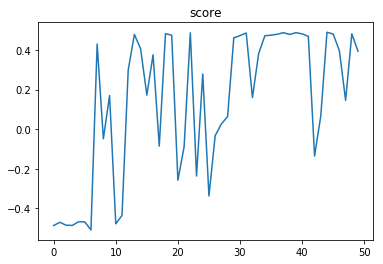

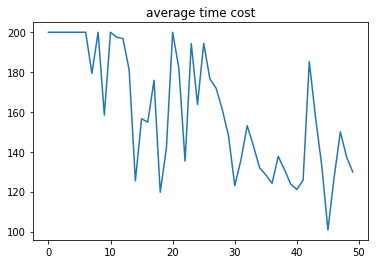

In [7]:
replays = deque(maxlen=10000)
gamma = 0.99
eps_high = 0.3
eps_low = 0.01
num_episodes = 500
LR = 0.001
batch_size = 10
log_step = 10

net = Sequential(
    Linear(2, 32),
    Tanh(),
    Linear(32,64),
    Tanh(),
    Linear(64,3)
)
agent = DQNAgent(net,1,gamma,LR)

score_list = []
time_cost_list = []

for episode in range(num_episodes):
    agent.eps = eps_high - (eps_high-eps_low)*(episode/num_episodes)
    
    s0 = env.reset()
    s = env.reset()
    done = False
    max_pos = -100
    t = 0
    
    while not done:
        t += 1
        max_pos = max(s0[0],max_pos)
        a0 = agent.sample(s0)
        s1, r1, done, _ = env.step(a0)
        
        # 使用max pos作为奖励
        if done:
            if max_pos >= 0.5:
                # 到达max pos的时间越早越好
                r1 = (max_pos+0.5)+100*(1-t/200)
            else:
                r1 = (max_pos+0.5)
        
        
        # 最终状态将在比较大的程度上影响训练，
        if not done:
            replay_rate = 0.1
        else:
            replay_rate = 1
        if random.random()<replay_rate:
            replays.append((s0.copy(),a0,r1,s1.copy(),done))
        
        s0 = s1
    
        if replays.__len__()>=batch_size:
            batch = random.sample(replays,k=batch_size)
            agent.learn(batch)
        
    if (episode+1)%log_step==0:
        score,t = evaluate(agent,env,10)
        score_list.append(score)
        time_cost_list.append(t)
        print("Episode: %d, Score: %.3f, average time cost: %.3f"%(episode+1,score,t))

plt.figure()
plt.plot(score_list)
plt.title('score')
plt.figure()
plt.plot(time_cost_list)
plt.title('average time cost')